<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [17]:
dataset, info = tfds.load('cifar10', split=tfds.Split.TRAIN, with_info = True)

dataset_airplanes   = dataset.filter(lambda x: x['label'] == 0)
dataset_automobile  = dataset.filter(lambda x: x['label'] == 1)
dataset_birds       = dataset.filter(lambda x: x['label'] == 2)
dataset_cats        = dataset.filter(lambda x: x['label'] == 3)
dataset_deers       = dataset.filter(lambda x: x['label'] == 4)
dataset_dogs        = dataset.filter(lambda x: x['label'] == 5)
dataset_frogs       = dataset.filter(lambda x: x['label'] == 6)
dataset_horses      = dataset.filter(lambda x: x['label'] == 7)
dataset_ships       = dataset.filter(lambda x: x['label'] == 8)
dataset_trucks      = dataset.filter(lambda x: x['label'] == 9)

for feature_dict in dataset_dogs:
  assert feature_dict['label'] == 5

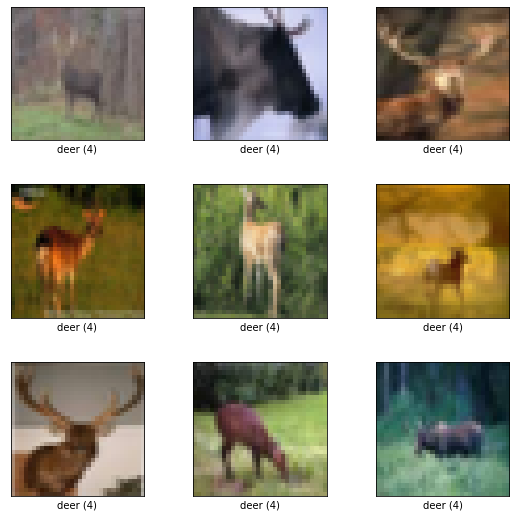

In [18]:
fig = tfds.show_examples(dataset_deers, info)

How to display one picture of a dataset using `next(iter(dataset)`

tf.Tensor(5, shape=(), dtype=int64)


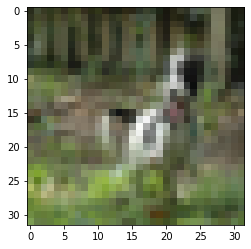

In [19]:
feature_dict = next(iter(dataset_dogs))

print(feature_dict['label'])
plt.imshow(feature_dict['image'])

# Get 10 samples from each dataset class

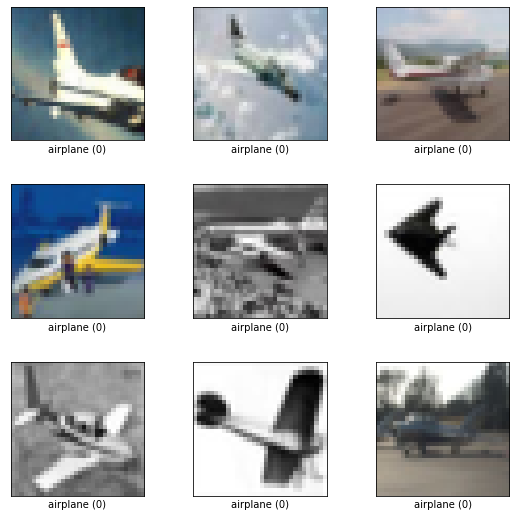

In [44]:
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

#

# mini_ds_airplanes = dataset_airplanes.skip(9)
# mini_ds_airplanes = mini_ds_airplanes.take(9)
# B = dataset_airplanes.shard(400, index=0)
# C = dataset_airplanes.shard(1000, index=1)
# list(B.as_numpy_iterator())
# list(C.as_numpy_iterator())


mini_ds_airplanes
# plt.imshow(feature_dict['image'])

fig = tfds.show_examples(mini_ds_airplanes, info)